Saving wave_scenes.mp4 to wave_scenes.mp4
Loaded 1344 frames at 15.0 fps, shape=(1080, 1920)
Auto ROI: (0, np.int64(126), 480, np.int64(144))


100%|██████████| 4/4 [00:00<00:00, 40.11it/s]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

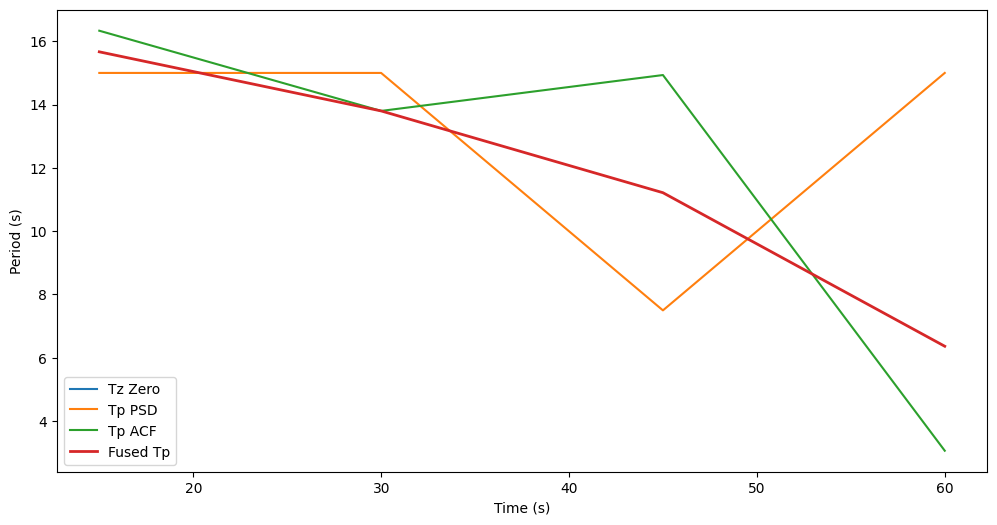

In [1]:
# ========================================
# 1) Setup
# ========================================
!pip install opencv-python numpy scipy matplotlib torch torchvision tqdm --quiet

import cv2
import numpy as np
from scipy import signal
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
import csv
from tqdm import tqdm
from google.colab import files

np.random.seed(42)

# ========================================
# 2) Modes & Toggles
# ========================================
HIGH_ACCURACY_MODE = False   # True = full res, stabilization, heavy flow
USE_STABILIZATION  = False   # Enable if camera shakes
AUTO_ROI           = True    # Enable automatic ROI detection

# ========================================
# 3) Utils
# ========================================
def bandpass_filter(sig, fs, low=0.04, high=0.3, order=4):
    sos = signal.butter(order, [low, high], btype='band', fs=fs, output='sos')
    return signal.sosfiltfilt(sos, sig, padlen=min(3*len(sig), 150))

def detrend(sig):
    return signal.detrend(sig)

def divergence(flow_u, flow_v):
    du_dx = np.gradient(flow_u, axis=1)
    dv_dy = np.gradient(flow_v, axis=0)
    return du_dx + dv_dy

# ========================================
# 4) Video Loader & Preprocessing
# ========================================
def load_video(video_path, fps_target=15, grayscale=True):
    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)
    frames = []
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret: break
        if grayscale:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        frames.append(frame)
    cap.release()
    step = max(1, int(fps / fps_target))
    return frames[::step], fps / step

def resize_frames(frames, max_width=640):
    resized = []
    for f in frames:
        if f.shape[1] > max_width:
            scale = max_width / f.shape[1]
            f = cv2.resize(f, (int(f.shape[1]*scale), int(f.shape[0]*scale)))
        resized.append(f)
    return resized

def stabilize_video(frames, max_iter=50):
    ref = frames[0]
    stabilized = [ref]
    for frame in frames[1:]:
        warp_matrix = np.eye(2, 3, dtype=np.float32)
        criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, max_iter, 1e-6)
        try:
            _, warp_matrix = cv2.findTransformECC(ref, frame, warp_matrix, cv2.MOTION_AFFINE, criteria)
            stabilized.append(cv2.warpAffine(frame, warp_matrix, (frame.shape[1], frame.shape[0]),
                                             flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP))
        except cv2.error:
            stabilized.append(frame)  # fallback
    return stabilized

# ========================================
# 5) ROI Selection
# ========================================
def select_roi(frame):
    return (0, frame.shape[0]//2, frame.shape[1], frame.shape[0]//2)

def auto_select_roi(frame, min_fraction=0.3):
    """
    Automatically detect horizon and select ROI covering water region.
    """
    h, w = frame.shape
    gx = cv2.Scharr(frame, cv2.CV_32F, 1, 0)
    gy = cv2.Scharr(frame, cv2.CV_32F, 0, 1)
    grad_mag = np.sqrt(gx**2 + gy**2)
    energy_profile = grad_mag.mean(axis=1)
    energy_profile = gaussian_filter(energy_profile, sigma=5)
    diffs = np.gradient(energy_profile)
    split_row = np.argmax(diffs)
    roi_height = max(int(h * min_fraction), h - split_row)
    y = min(split_row, h - roi_height)
    return (0, y, w, roi_height)

# ========================================
# 6) Optical Flow & Ridges
# ========================================
def compute_flow_farneback(frames, pyr_scale=0.5, levels=2, winsize=15, iterations=2, poly_n=5, poly_sigma=1.2):
    flows = []
    for i in range(1, len(frames)):
        flow = cv2.calcOpticalFlowFarneback(frames[i-1], frames[i], None, pyr_scale, levels, winsize, iterations, poly_n, poly_sigma, 0)
        flows.append(flow)
    return flows

def detect_ridges(frame, sigma=1.0):
    blurred = gaussian_filter(frame, sigma)
    dx = cv2.Scharr(blurred, cv2.CV_32F, 1, 0)
    dy = cv2.Scharr(blurred, cv2.CV_32F, 0, 1)
    dxx = cv2.Scharr(dx, cv2.CV_32F, 1, 0)
    dxy = cv2.Scharr(dx, cv2.CV_32F, 0, 1)
    dyy = cv2.Scharr(dy, cv2.CV_32F, 0, 1)
    hessian = dxx * dyy - dxy**2
    ridges = np.maximum(hessian, 0)
    ridges[ridges < np.max(ridges)*0.1] = 0
    return ridges

# ========================================
# 7) Signals
# ========================================
def scanline_toa(frame, y1, y2):
    """
    Estimate relative delay using cross-correlation between scanlines.
    """
    line1 = frame[y1, :] - np.mean(frame[y1, :])
    line2 = frame[y2, :] - np.mean(frame[y2, :])
    corr = signal.correlate(line1, line2, mode="full")
    lag = np.argmax(corr) - (len(line1)-1)
    delta_t = lag / frame.shape[1]   # normalized lag
    return delta_t

def build_signals(frames, flows, roi):
    x, y, w, h = roi
    signals = {"crest_energy": [], "speed": [], "crest_count": [], "toa_delta": []}
    y1, y2 = h//4, 3*h//4
    for i, frame in enumerate(frames):
        crop = frame[y:y+h, x:x+w]
        ridges = detect_ridges(crop)
        gx = cv2.Scharr(crop, cv2.CV_32F, 1, 0)
        gy = cv2.Scharr(crop, cv2.CV_32F, 0, 1)
        grad_mag = np.sqrt(gx**2 + gy**2)
        signals["crest_energy"].append(np.mean(np.abs(grad_mag)))
        signals["crest_count"].append(len(signal.find_peaks(ridges.flatten(), height=np.max(ridges)*0.2)[0]))
        if flows and i > 0:
            flow_crop = flows[i-1][y:y+h, x:x+w]
            signals["speed"].append(np.mean(np.linalg.norm(flow_crop, axis=2)))
        signals["toa_delta"].append(scanline_toa(crop, y1, y2))
    for k in signals:
        signals[k] = np.array(signals[k])
    return signals

# ========================================
# 8) Period Estimators & Fusion
# ========================================
def zero_upcross(sig, fs):
    sig = detrend(sig)
    sig = bandpass_filter(sig, fs)
    crossings = np.diff(np.sign(sig)) > 0
    intervals = np.diff(np.nonzero(crossings)[0]) / fs
    return np.mean(intervals) if len(intervals) else np.nan

def welch_psd_tp(sig, fs, nperseg=None):
    sig = detrend(sig)
    sig = bandpass_filter(sig, fs)
    if nperseg is None:
        nperseg = len(sig) // 2
    f, Pxx = signal.welch(sig, fs=fs, nperseg=nperseg)
    if len(f) == 0: return np.nan
    peak_f = f[np.argmax(Pxx)]
    return 1 / peak_f if peak_f > 0 else np.nan

def acf_tp(sig, fs, min_lag=3, max_lag=25):
    sig = detrend(sig)
    sig = bandpass_filter(sig, fs)
    acf = signal.correlate(sig, sig, mode='full')
    acf = acf[len(acf)//2:]
    lags = np.arange(len(acf)) / fs
    mask = (lags >= min_lag) & (lags <= max_lag)
    if np.any(mask):
        peak_lag = lags[mask][np.argmax(acf[mask])]
        return peak_lag
    return np.nan

def fuse_tp(tps, snrs=None):
    if snrs is None:
        snrs = [1] * len(tps)
    valid = [t for t, s in zip(tps, snrs) if not np.isnan(t)]
    weights = [s for t, s in zip(tps, snrs) if not np.isnan(t)]
    if valid:
        fused = np.median(valid)
        conf = np.mean(weights)
    else:
        fused, conf = np.nan, 0
    return fused, conf

# ========================================
# 9) Rolling Adaptive Tp
# ========================================
def rolling_tp(signals, fs, window_sec=60, overlap=0.5):
    n = len(signals["crest_energy"])
    total_sec = n / fs
    if total_sec < window_sec:
        window_sec = max(5, total_sec * 0.3)
        print(f"[Adaptive] Using shorter window: {window_sec:.1f}s")
    step = int(window_sec * fs * (1 - overlap))
    win_len = int(window_sec * fs)
    tps = {"zero": [], "psd": [], "acf": [], "fused": []}
    confs, times = [], []
    for start in tqdm(range(0, n - win_len, step)):
        end = start + win_len
        seg_energy = signals["crest_energy"][start:end]
        seg_speed  = signals["speed"][start:end]
        tp_zero = zero_upcross(seg_energy, fs)
        tp_psd  = welch_psd_tp(seg_speed, fs)
        tp_acf  = acf_tp(seg_energy, fs)
        snrs = [1.0, 2.0, 1.5]
        tp_fused, conf = fuse_tp([tp_zero, tp_psd, tp_acf], snrs)
        mid_time = (start + win_len//2) / fs
        times.append(mid_time)
        tps["zero"].append(tp_zero)
        tps["psd"].append(tp_psd)
        tps["acf"].append(tp_acf)
        tps["fused"].append(tp_fused)
        confs.append(conf)
    for k in tps: tps[k] = np.array(tps[k])
    return np.array(times), tps, np.array(confs)

# ========================================
# 10) Export + Visualization
# ========================================
def save_rolling_csv(out_path, times, tps, confs):
    with open(out_path, 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(['time_mid_s', 'Tp_zero', 'Tp_psd', 'Tp_acf', 'Tp_fused', 'confidence'])
        for t, z, p, a, fval, c in zip(times, tps['zero'], tps['psd'], tps['acf'], tps['fused'], confs):
            writer.writerow([t, z, p, a, fval, c])

def render_overlay_with_tp(frames, roi, times, tps, fs, window_sec=60, overlap=0.5):
    out_frames = []
    x, y, w, h = roi
    step = int(window_sec * fs * (1 - overlap))
    for i, frame in enumerate(frames):
        frame_color = cv2.cvtColor(frame, cv2.COLOR_GRAY2BGR)
        cv2.rectangle(frame_color, (x, y), (x+w, y+h), (0,255,0), 2)
        win_idx = i // step
        if win_idx < len(tps["fused"]):
            tp_val = tps["fused"][win_idx]
            if not np.isnan(tp_val):
                cv2.putText(frame_color, f"Tp~{tp_val:.1f}s", (30, 40),
                            cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2)
        out_frames.append(frame_color)
    return out_frames

def save_video(out_path, frames, fps=15):
    h, w = frames[0].shape[:2]
    out = cv2.VideoWriter(out_path, cv2.VideoWriter_fourcc(*'mp4v'), fps, (w, h))
    for frame in frames:
        out.write(frame)
    out.release()

# ========================================
# 11) Run Example
# ========================================
uploaded = files.upload()
VIDEO_PATH = list(uploaded.keys())[0]

frames, fs = load_video(VIDEO_PATH, fps_target=15)
print(f"Loaded {len(frames)} frames at {fs:.1f} fps, shape={frames[0].shape}")

if not HIGH_ACCURACY_MODE:
    frames = resize_frames(frames, max_width=480)
if USE_STABILIZATION:
    frames = stabilize_video(frames, max_iter=30)

# ROI selection
if AUTO_ROI:
    roi = auto_select_roi(frames[0])
    print(f"Auto ROI: {roi}")
else:
    roi = select_roi(frames[0])

if HIGH_ACCURACY_MODE:
    flows = compute_flow_farneback(frames, levels=3, winsize=25, iterations=3)
else:
    flows = compute_flow_farneback(frames, levels=2, winsize=15, iterations=2)

signals = build_signals(frames, flows, roi)

times, tps, conf = rolling_tp(signals, fs, window_sec=30, overlap=0.5)

save_rolling_csv("rolling_results.csv", times, tps, conf)
preview_video = render_overlay_with_tp(frames, roi, times, tps, fs, window_sec=30, overlap=0.5)
save_video("rolling_preview.mp4", preview_video, fps=int(fs))

try:
    files.download("rolling_results.csv")
    files.download("rolling_preview.mp4")
except:
    print("Skipping download (not in Colab).")

plt.figure(figsize=(12,6))
plt.plot(times, tps["zero"], label="Tz Zero")
plt.plot(times, tps["psd"], label="Tp PSD")
plt.plot(times, tps["acf"], label="Tp ACF")
plt.plot(times, tps["fused"], label="Fused Tp", linewidth=2)
plt.xlabel("Time (s)")
plt.ylabel("Period (s)")
plt.legend()
plt.show()
